In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import csv
# BERT Eval
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import pickle
from collections import Counter
# LSTM Eval
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Using TensorFlow backend.


# BERT

## Model Selection

In [2]:
# uploading training statistics for BERT Model with punctuation (aka punt) and without (aka no_punt)
df_stats_punt = pd.read_csv('Model Selection\Models\BERT\with_punt\BERT_PUNT_training_stats.csv')
df_stats_nopunt = pd.read_csv('Model Selection\Models\BERT\no_punt\BERT_NOPUNT_training_stats.csv')
print(df_stats_punt)

   epoch  Training Loss  Valid. Loss  Valid. Accur.  Vaid. F1 Score
0      1       0.511255     0.467827       0.855572        0.855764
1      2       0.432794     0.511429       0.862650        0.864917
2      3       0.323738     0.654744       0.869805        0.871405
3      4       0.218369     0.765261       0.869501        0.871105


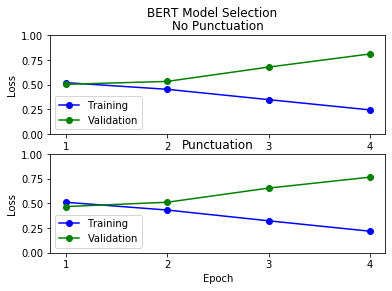

In [3]:
fig, axs = plt.subplots(2)
fig.suptitle('BERT Model Selection')
# Set the ticks and ticklabels for all axes
plt.setp(axs, xticks=[1, 2, 3, 4], xlabel='Epoch', ylabel='Loss', ylim=0)
axs[0].plot([1, 2, 3, 4], df_stats_nopunt['Training Loss'], 'b-o', label="Training")
axs[0].plot([1, 2, 3, 4], df_stats_nopunt['Valid. Loss'], 'g-o', label="Validation")
axs[0].legend(loc="lower left")
axs[0].set_title("No Punctuation")
axs[1].plot([1, 2, 3, 4], df_stats_punt['Training Loss'], 'b-o', label="Training")
axs[1].plot([1, 2, 3, 4], df_stats_punt['Valid. Loss'], 'g-o', label="Validation")
axs[1].legend(loc="lower left")
axs[1].set_title("Punctuation")
plt.show()

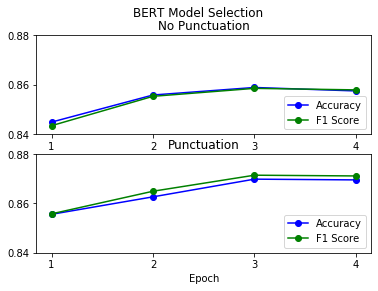

In [4]:
fig, axs = plt.subplots(2)
fig.suptitle('BERT Model Selection')
# Set the ticks and ticklabels for all axes
plt.setp(axs, xticks=[1, 2, 3, 4], xlabel='Epoch')
axs[0].plot([1, 2, 3, 4], df_stats_nopunt['Valid. Accur.'], 'b-o', label="Accuracy")
axs[0].plot([1, 2, 3, 4], df_stats_nopunt['Vaid. F1 Score'], 'g-o', label="F1 Score")
axs[0].set_ylim([0.84,0.88])
axs[0].legend(loc="lower right")
axs[0].set_title("No Punctuation")
axs[1].plot([1, 2, 3, 4], df_stats_punt['Valid. Accur.'], 'b-o', label="Accuracy")
axs[1].plot([1, 2, 3, 4], df_stats_punt['Vaid. F1 Score'], 'g-o', label="F1 Score")
axs[1].set_ylim([0.84,0.88])
axs[1].legend(loc="lower right")
axs[1].set_title("Punctuation")
plt.show()

## Model Evaluation

The Best BERT Model is the one obtained with training set with punctuation (wrt to no punctuation one) 

In [5]:
'''
Compute Performances Metrics
'''
def f1_score_func(preds, labels):
    preds_new = np.where(preds.flatten()>0.5, 1,0).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_new, pos_label=1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    preds_new = np.where(preds.flatten()>0.5, 1, 0)
    labels_flat = labels.flatten()
    return np.sum(preds_new == labels_flat) / len(labels_flat)

In [6]:
def evaluate(dataloader_val, model, device): 
    model.eval()

    total_eval_accuracy = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        batch_input = batch[0]
        batch_target = batch[1]

        with torch.no_grad():        
            outputs = model(batch_input)

        logits = outputs['logits']   
        logits = torch.sigmoid(logits)

        logits = logits.detach().cpu().numpy()
        label_ids = batch_target.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(dataloader_val)
    return predictions, true_vals, avg_val_accuracy

In [7]:
def TestSet_Evaluation(df, model_path):
    # setting device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    '''
    Data Preparation
    '''
    # dropping unecessary columns for classification
    df.drop(columns=['text', 'tokenized', 'length'], inplace=True)
    print('n_articles for each label:', df['pol_leaning'].value_counts())

    # BertTokenizer: tokenizing texts and turning them into integers vectors
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
    # encoding tokenized texts to indexes
    encoded_data_val = tokenizer.batch_encode_plus(
    df.clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=False, 
    padding=True, 
    truncation=True, 
    return_tensors='pt'
    )
    input_ids_val = encoded_data_val['input_ids']
    labels_val = torch.tensor(df.pol_leaning.values)
    dataset_val = TensorDataset(input_ids_val, labels_val)
    print('end tokenization and encoding')
    batch_size = 4
    # iterable DatLoader
    dataloader_testset = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
    '''
    Loading and Evaluating Model
    '''
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=1,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
    model.to(device)
    model.load_state_dict(torch.load(model_path))

    predictions, true_vals, avg_accuracy = evaluate(dataloader_testset, model, device)
    return predictions
    # Computing Test Set performances
    print('\n')
    val_f1 = f1_score_func(predictions, true_vals)
    print(f'F1 Score: {round(val_f1,3)}')
    print('\n')
    print('Accuracy:',avg_accuracy)

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv(r'ground_truth_datasets\PUNT_cleaned_TestSet_LSTM.csv')
model_path = 'Model Selection\Models\BERT\with_punt\finetuned_BERT_epoch_1.model'
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
TestSet_Evaluation(df, model_path)

### PUNT

In [8]:
# Open Model predictions on Test Set and compute performances
with open(r'C:\Users\virgi\Desktop\ASSEGNO\Paper_ec\Model Selection/Models/BERT/with_punt/PUNT_predictionsBERT_refactored.pickle', "rb") as input_file:
     predictions = pickle.load(input_file)
prob_pred = predictions[0]
true_label = predictions[1]
pred_label = np.where(prob_pred.flatten()>0.5, 1,0).flatten()
print('Test Set Accuracy', flat_accuracy(predictions[0], predictions[1]))
print('Test Set F1 score', f1_score_func(predictions[0], predictions[1]))

Test Set Accuracy 0.8557
Test Set F1 score 0.8553480134995155


In [9]:
# Confusion Matrix
actual = true_label
predicted = pred_label
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[25744  4430]
 [ 4228 25598]]
Accuracy Score : 0.8557
Classification Report : 
             precision    recall  f1-score   support

          0       0.86      0.85      0.86     30174
          1       0.85      0.86      0.86     29826

avg / total       0.86      0.86      0.86     60000



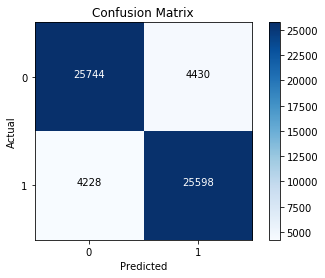

In [10]:
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(true_label))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

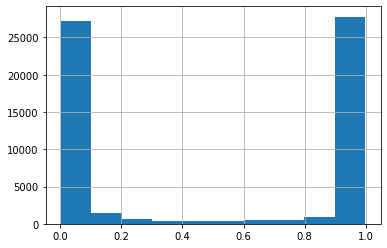

In [11]:
# Dataset to analyze probability distributions
test_data = df = pd.read_csv('ground_truth_datasets\PUNT_cleaned_TestSet_LSTM.csv')
test_data.drop(columns=['text', 'tokenized', 'length'], inplace=True)
test_data['pred_prob'] = prob_pred
test_data['pred_label'] = pred_label
test_data['true_label'] = true_label
test_data['pred_prob'].hist()

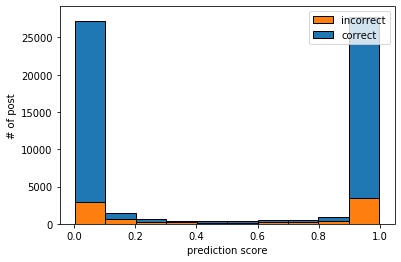

In [12]:
# analyzing density of wrong and right probability predictions
correct_pred = test_data[test_data['true_label'] == test_data['pred_label']]
err_pred = test_data[test_data['true_label'] != test_data['pred_label']]
# plot
n_bins=10
colors =['tab:orange','tab:blue']
plt.hist([err_pred['pred_prob'],correct_pred['pred_prob']], n_bins, histtype='bar', stacked=True, edgecolor='black', label=['incorrect','correct'], color=colors)
plt.legend(loc="upper right")
plt.xlabel('prediction score')
plt.ylabel('# of post')
plt.show()

# LSTM

## Model Selection

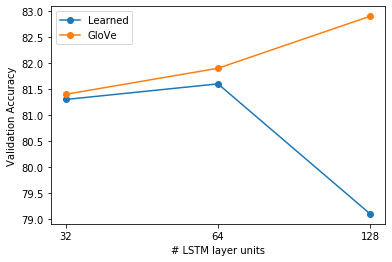

In [14]:
# Comparison between LSTM Models with learned and Glove Word Embeddings (with fixed 100 dimension)
LSTM_units= ['32','64','128']
accuracy = [81.3,81.6,79.1]
plt.plot(LSTM_units, accuracy, marker='o', label = "Learned")
LSTM_units = ['32','64','128']
accuracy = [81.4,81.9,82.9]
plt.plot(LSTM_units, accuracy, marker='o', label = "GloVe")
plt.xlabel('# LSTM layer units')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [15]:
from LSTM_predict import LSTModel
# open ground truth df
test_data = pd.read_csv('ground_truth_datasets\NOPUNT_cleaned_TestSet_LSTM.csv') 
# making predictions
file_model = 'Model Selection\Models\LSTM\LSTM_model_glove.json'
file_weights = 'Model Selection\Models\LSTM\LSTM_model_glove.h5'
file_tokenizer = 'Model Selection\Models\LSTM\LSTM_tokenizer_def.pickle'
model = LSTModel(file_model, file_weights, file_tokenizer)
pred_prob = model.predict_prob(test_data['clean_text'].astype(str))
pred_label = model.predict_class(test_data['clean_text'].astype(str)) 
# building df with author, post and predictions
true_label = test_data['pol_leaning'] 
pred_prob = pred_prob.T
pred_label = pred_label.T
test_data['pred_prob'] = pred_prob[0]
test_data['pred_label'] = pred_label[0]
test_data['true_label'] = true_label

In [16]:
# Confusion Matrix
actual = true_label
predicted = pred_label[0]
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[24585  5407]
 [ 4821 25187]]
Accuracy Score : 0.8295333333333333
Classification Report : 
             precision    recall  f1-score   support

          0       0.84      0.82      0.83     29992
          1       0.82      0.84      0.83     30008

avg / total       0.83      0.83      0.83     60000



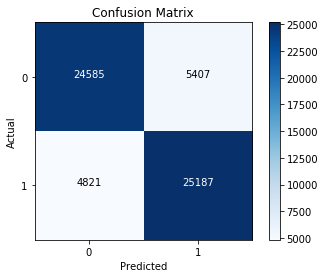

In [17]:
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(true_label))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

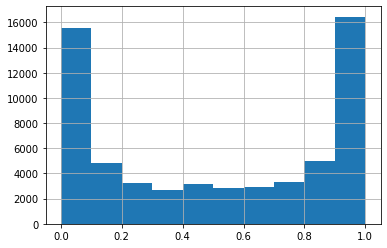

In [18]:
# prediction probabilty distribution
test_data['pred_prob'].hist()

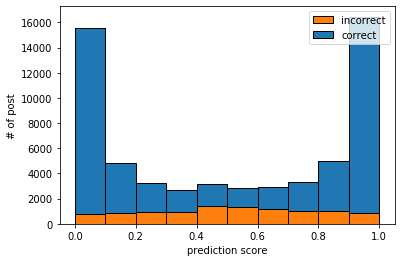

In [19]:
# analyzing density of wrong and right probability predictions
correct_data = test_data[test_data['true_label'] == test_data['pred_label']]
err_data = test_data[test_data['true_label'] != test_data['pred_label']]
# plot
n_bins=10
colors =['tab:orange','tab:blue']
plt.hist([err_data['pred_prob'],correct_data['pred_prob']], n_bins, histtype='bar', stacked=True, edgecolor='black', label=['incorrect','correct'], color=colors)
plt.legend(loc="upper right")
plt.xlabel('prediction score')
plt.ylabel('# of post')
plt.show()